In [1]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model import *
import numpy as np
import statsmodels.tsa.vector_ar.var_model as VAR
from datetime import datetime
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Load data

In [2]:
cleansed=load_amihud_markets_price()

tsmom_model.py:146: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:148: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud = \frac{|r_t|}{\text{volume}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [3]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:29: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:31: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:33: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:33: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:36: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future versio

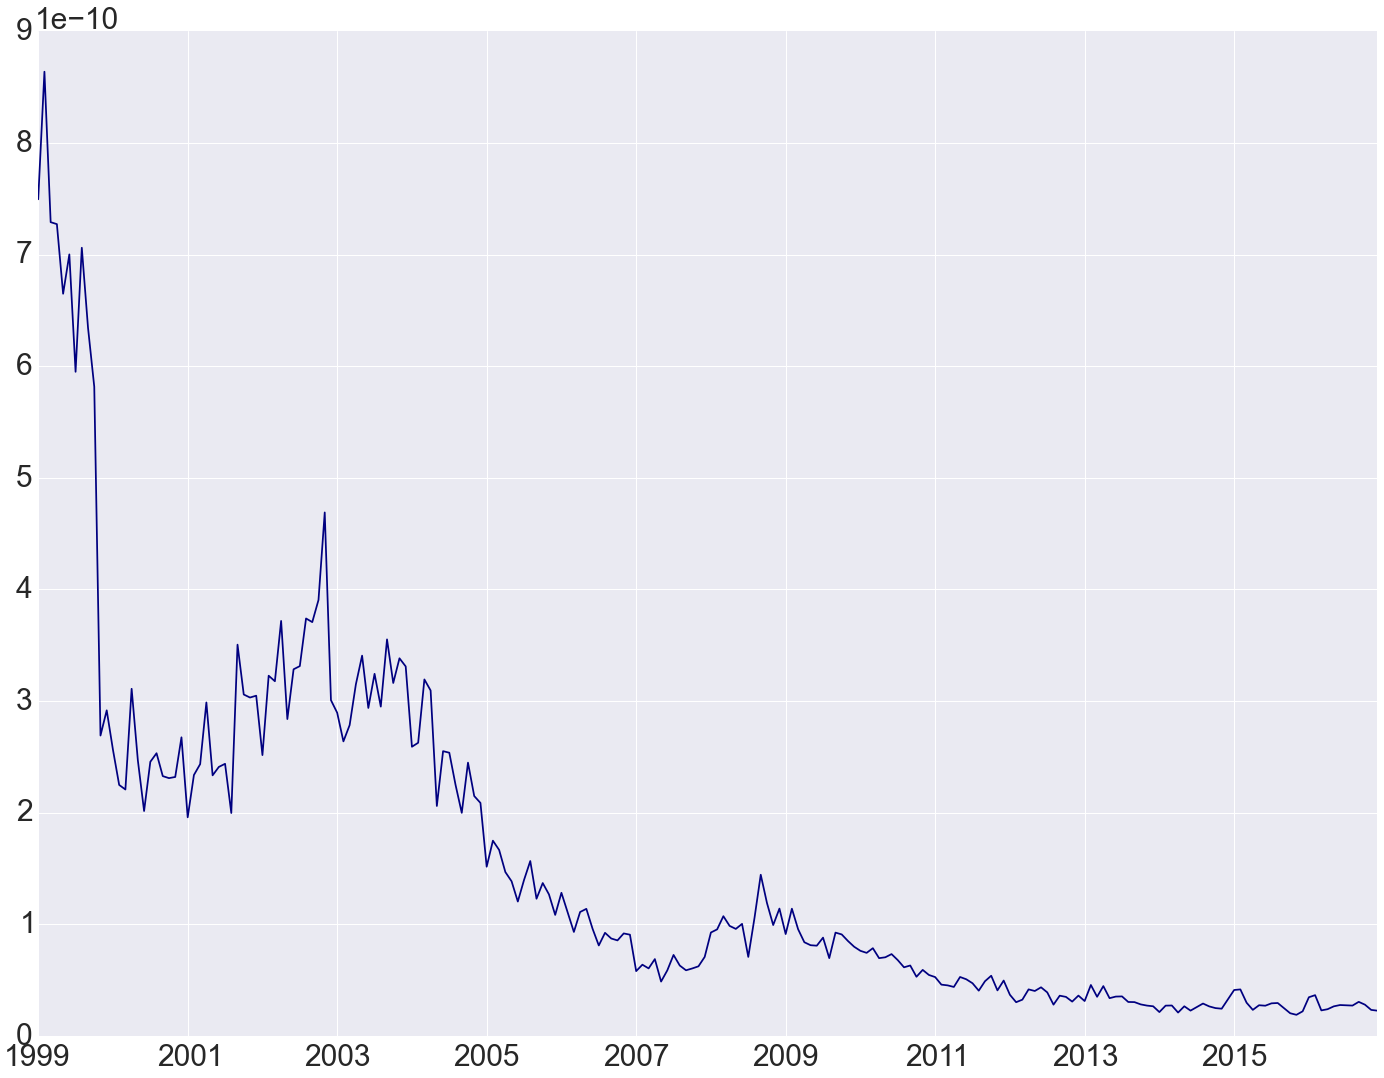

In [4]:
amihud.median(axis=1).dropna().plot(colormap='jet')

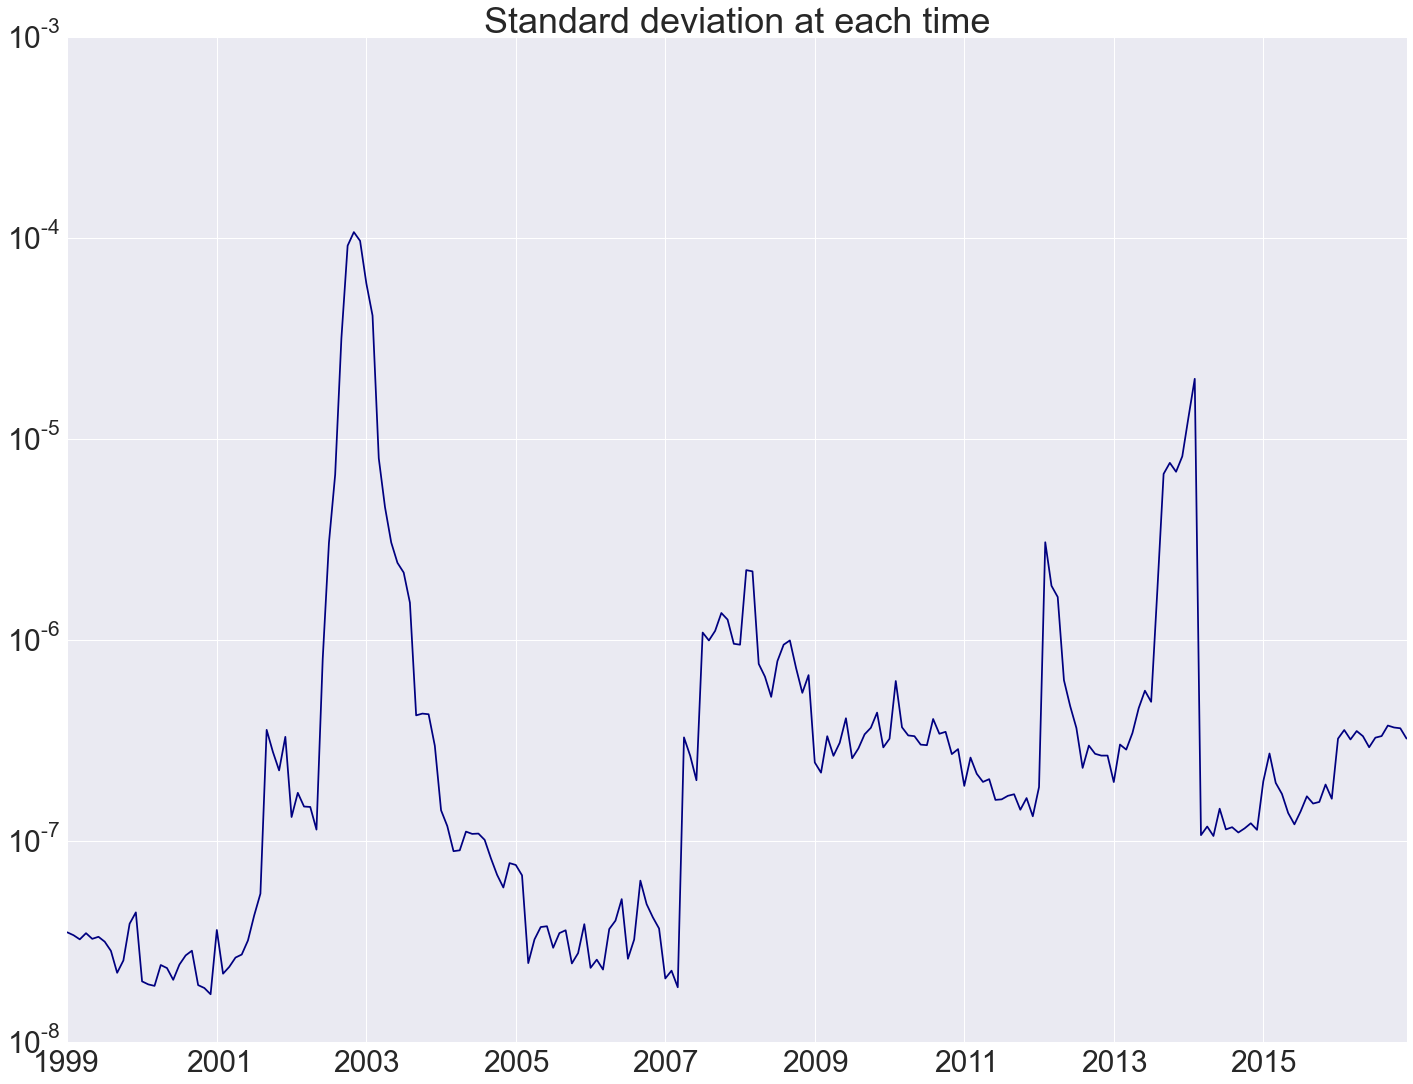

In [5]:
amihud.std(axis=1).dropna().plot(logy=True,colormap='jet',title='Standard deviation at each time')

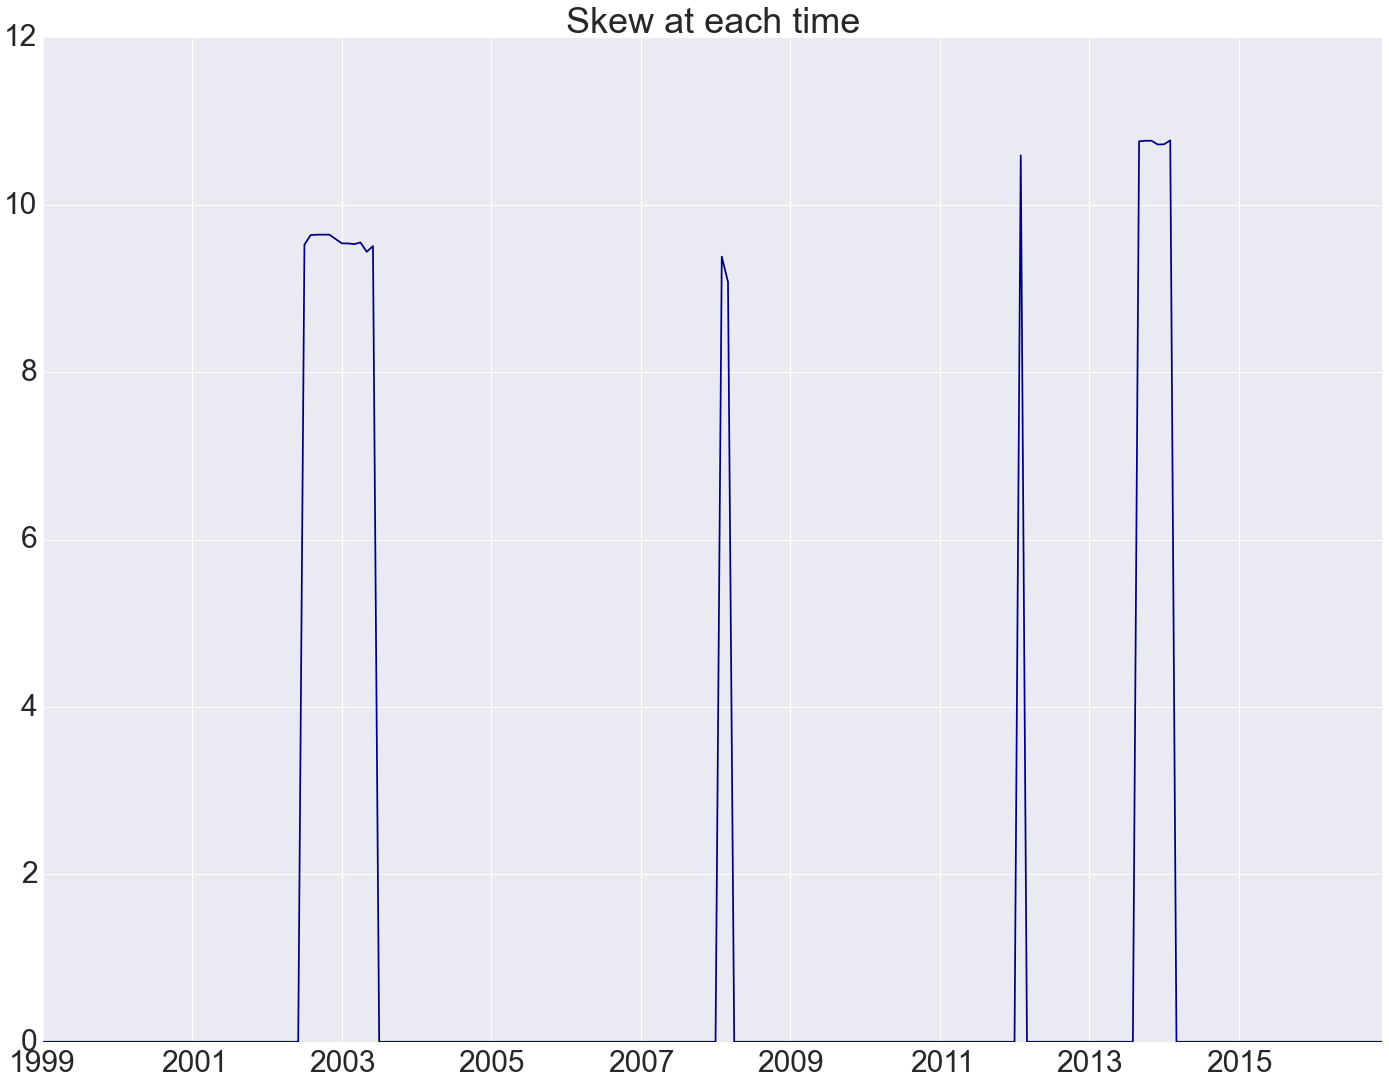

In [6]:
amihud.skew(axis=1).dropna().plot(logy=False,colormap='jet',title='Skew at each time')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


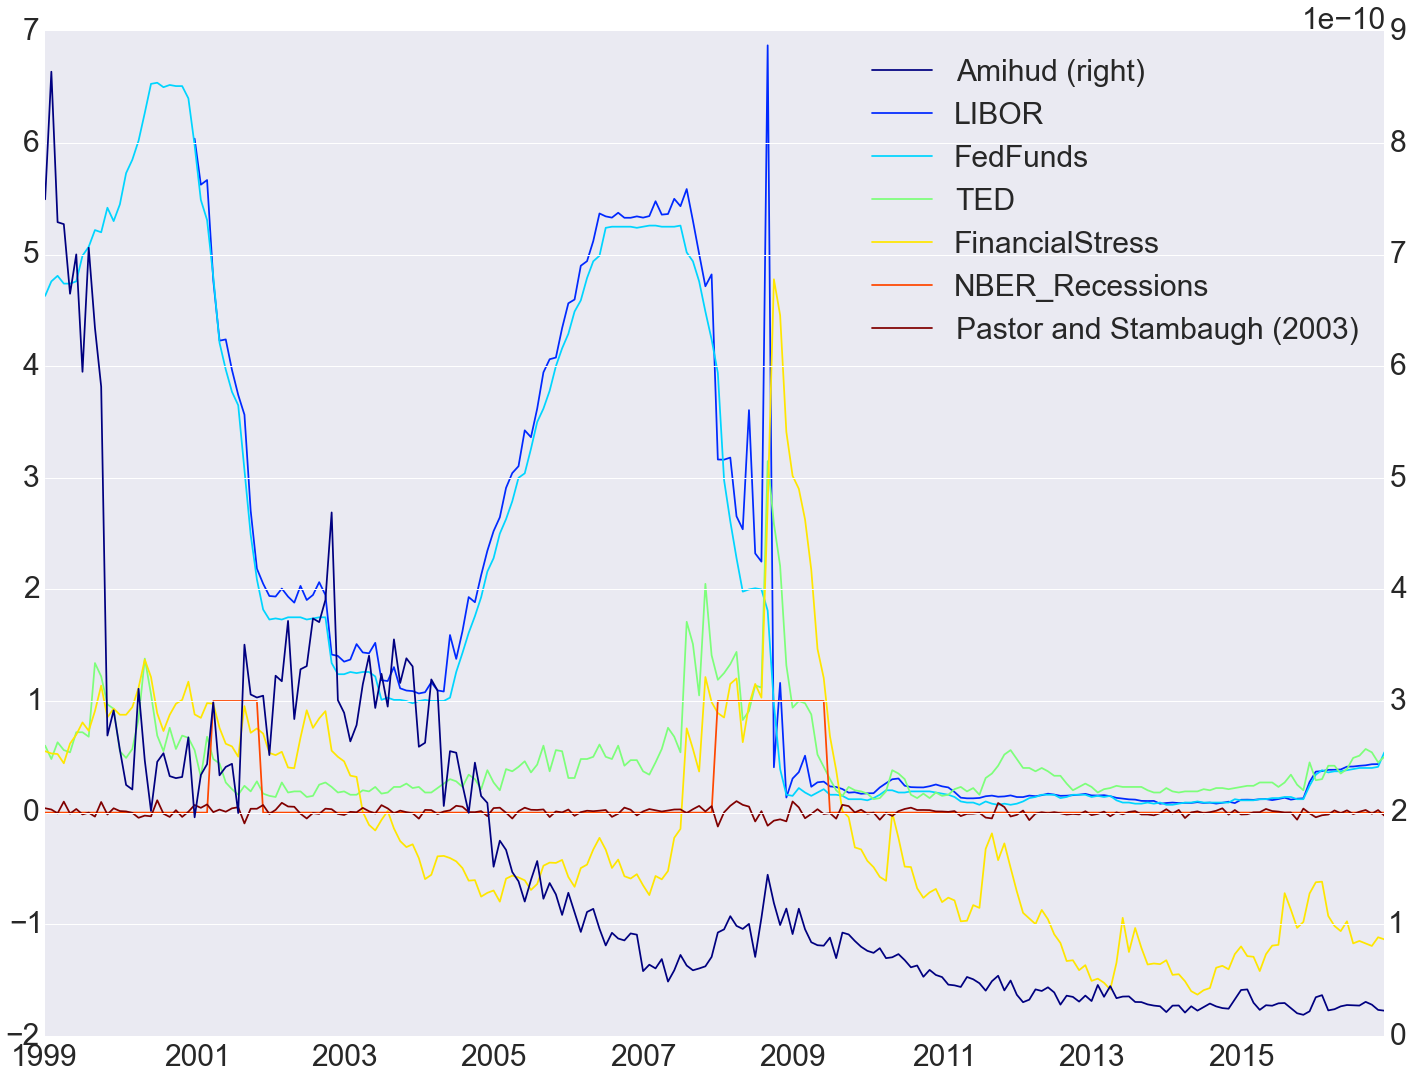

In [7]:
PS=pd.read_csv('PS.csv',parse_dates=[0]).set_index('Month').resample(rule='m',how='last')
factors=pd.read_csv('market_liquidity_factors.csv',index_col=0,parse_dates=[0])
factors['Pastor and Stambaugh (2003)']=PS['Traded liquidity factor']
factors.plot(secondary_y='Amihud',colormap='jet')

In [8]:
factors['Amihud']=np.log(amihud.median(axis=1).dropna())

I need to understand what the VAR should look like.  Previously I used something that looked like this:

$$ X_t = \mu + \Phi X_{t-1} - \Sigma \varepsilon_t $$

But what is X in this case?

In [9]:
factors.columns

Index([u'Amihud', u'LIBOR', u'FedFunds', u'TED', u'FinancialStress',
       u'NBER_Recessions', u'Pastor and Stambaugh (2003)'],
      dtype='object')

In [10]:
res = VAR.VAR(endog=factors.dropna()).fit()
print res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 13, Aug, 2017
Time:                     06:13:56
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -26.5654
Nobs:                     190.000    HQIC:                  -27.1348
Log likelihood:           783.443    FPE:                1.11509e-12
AIC:                     -27.5224    Det(Omega_mle):     8.35468e-13
--------------------------------------------------------------------
Results for equation Amihud
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                 -1.227618         0.578624           -2.122           0.035
L1.Amihud                              0.946772         0.025581           37.011        

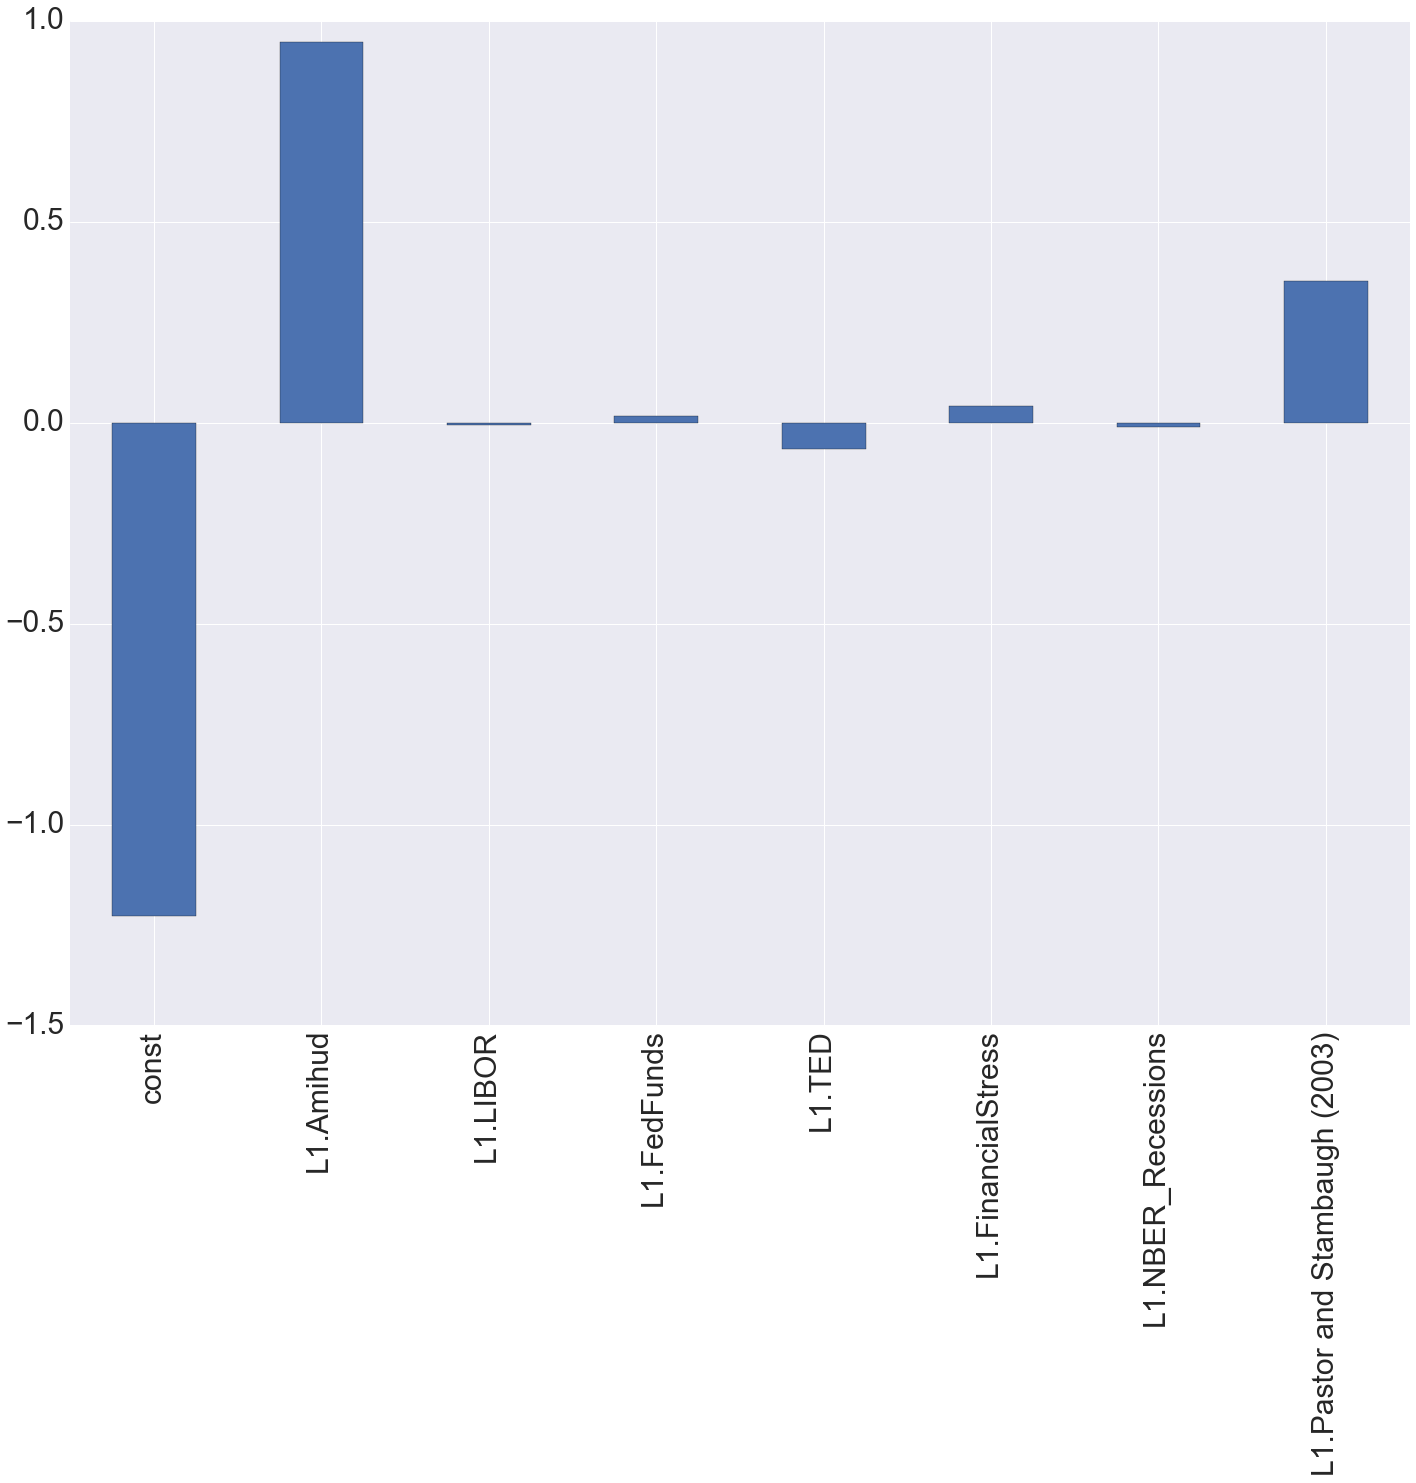

In [11]:
res.params.Amihud.plot(kind='bar')

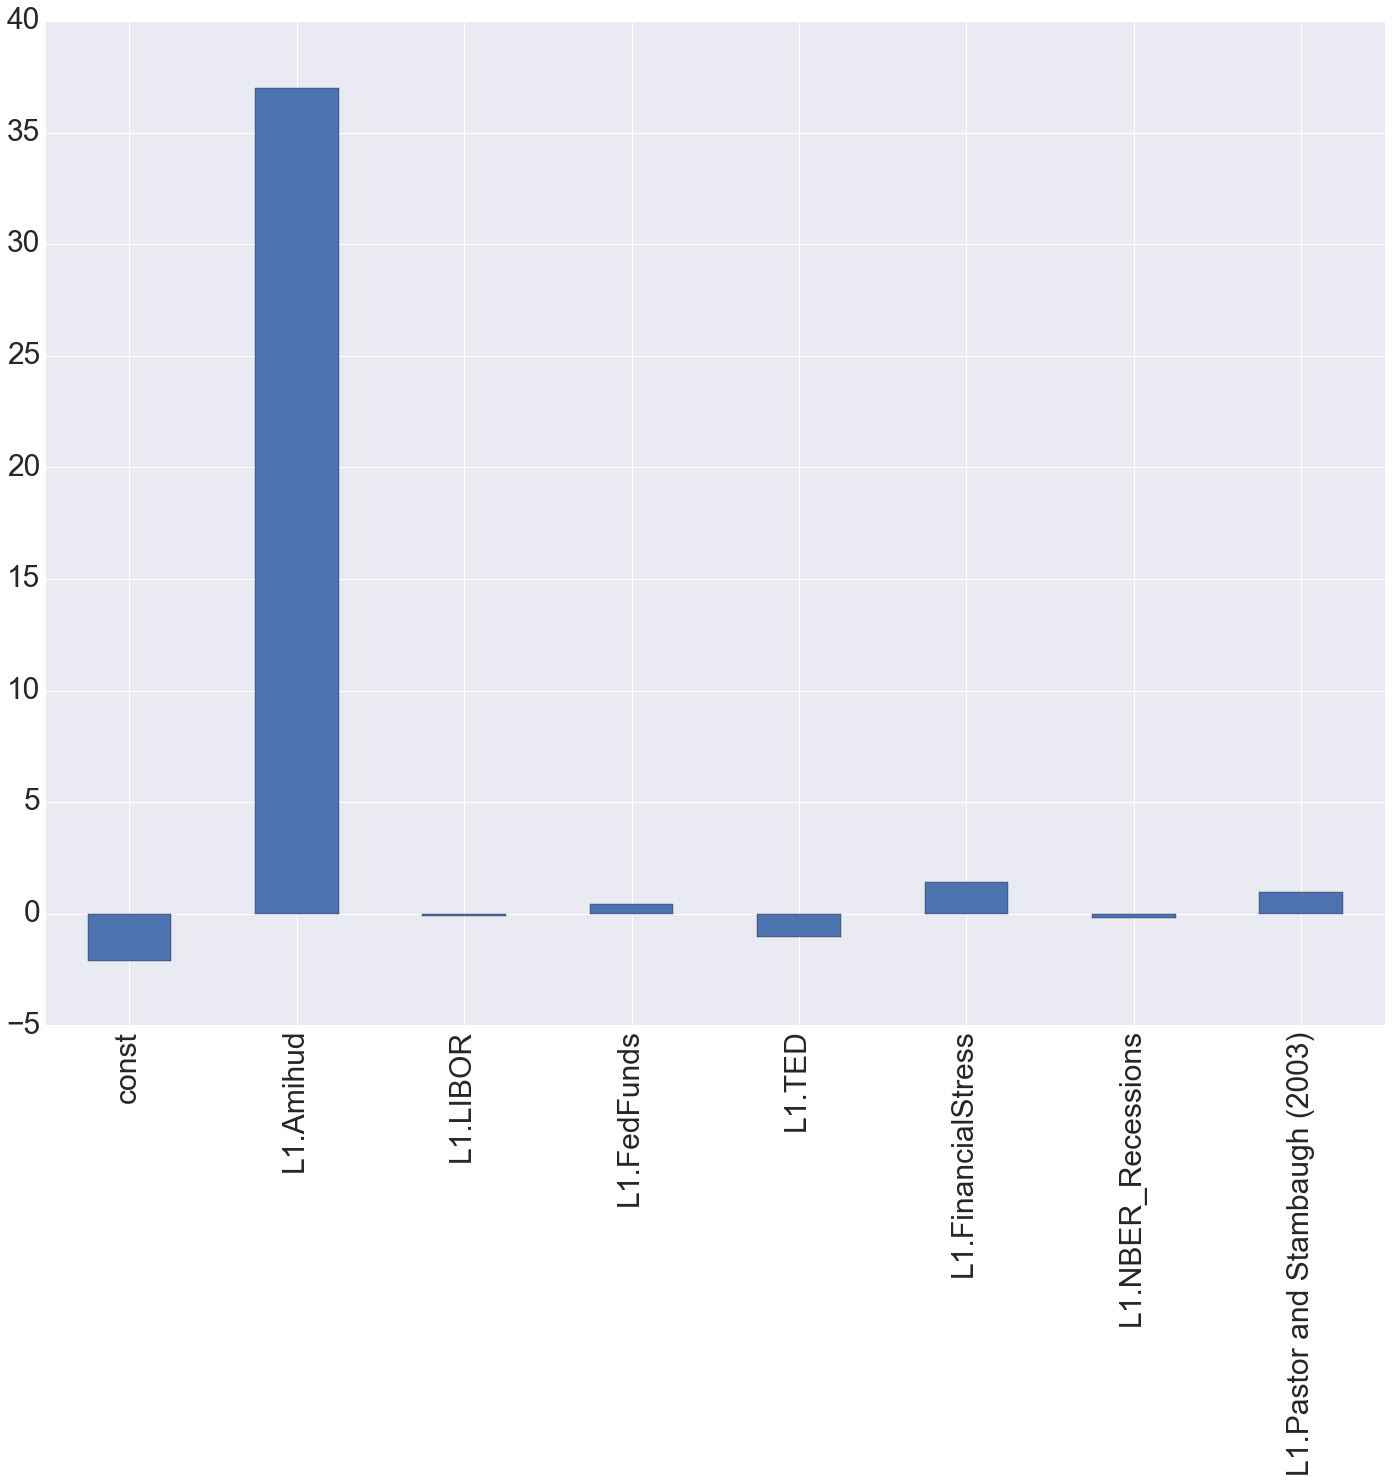

In [12]:
res.tvalues.Amihud.plot(kind='bar')

In [13]:
df=pd.DataFrame()
df['Values']=res.params.Amihud
df['Tstat']=res.tvalues.Amihud

In [14]:
df

,Values,Tstat
const,-1.227618,-2.121615
L1.Amihud,0.946772,37.011162
L1.LIBOR,-0.004484,-0.112737
L1.FedFunds,0.016509,0.424252
L1.TED,-0.064999,-1.026093
L1.FinancialStress,0.041659,1.443971
L1.NBER_Recessions,-0.010109,-0.188216
L1.Pastor and Stambaugh (2003),0.353503,0.972452


In [15]:
x=res.params.Amihud

In [16]:
y=pd.DataFrame()
y['Results']=res.params.Amihud.append(res.tvalues.Amihud)

In [17]:
print y.round(2).to_latex()

\begin{tabular}{lr}
\toprule
{} &  Results \\
\midrule
const                          &    -1.23 \\
L1.Amihud                      &     0.95 \\
L1.LIBOR                       &    -0.00 \\
L1.FedFunds                    &     0.02 \\
L1.TED                         &    -0.06 \\
L1.FinancialStress             &     0.04 \\
L1.NBER\_Recessions             &    -0.01 \\
L1.Pastor and Stambaugh (2003) &     0.35 \\
const                          &    -2.12 \\
L1.Amihud                      &    37.01 \\
L1.LIBOR                       &    -0.11 \\
L1.FedFunds                    &     0.42 \\
L1.TED                         &    -1.03 \\
L1.FinancialStress             &     1.44 \\
L1.NBER\_Recessions             &    -0.19 \\
L1.Pastor and Stambaugh (2003) &     0.97 \\
\bottomrule
\end{tabular}



In [21]:
res = VAR.VAR(endog=factors.dropna()).fit(2)
print res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 13, Aug, 2017
Time:                     06:23:24
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -26.5223
Nobs:                     189.000    HQIC:                  -27.5936
Log likelihood:           904.292    FPE:                5.01628e-13
AIC:                     -28.3233    Det(Omega_mle):     2.93903e-13
--------------------------------------------------------------------
Results for equation Amihud
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                 -0.736474         0.621002           -1.186           0.237
L1.Amihud                              0.683480         0.075054            9.106        

In [20]:
res = VAR.VAR(endog=factors.dropna()).fit(3)
print res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 13, Aug, 2017
Time:                     06:22:56
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -26.1255
Nobs:                     188.000    HQIC:                  -27.7025
Log likelihood:           991.679    FPE:                3.20440e-13
AIC:                     -28.7766    Det(Omega_mle):     1.47678e-13
--------------------------------------------------------------------
Results for equation Amihud
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                 -0.799677         0.665029           -1.202           0.231
L1.Amihud                              0.658135         0.078462            8.388        